# Loss of Function Variants in GnomAD Populations

We'd like to estimate what genes are enriched for loss of function (LoF) variants
in specific GnomAD populations relative to non-Finnish Europeans (NFE). Since we 
are interested in LoF variants, I'm looking at the GnomAD exome VCF file.

We'll use the PIEMM model introduced in http://biorxiv.org/content/early/2016/09/25/077180. 

In [1]:
import cPickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
import scipy.stats as stats
import seaborn as sns

from IPython.display import display, HTML

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R

source("PIEMM.r")

In [3]:
# Bring piemm function into python.
piemm_fnc = robjects.r['piemm']

def piemm(betas, ses, priorvar0=0.3**2, paramfix=True, var1fix=1, var2fix=1):
    """Wrapper around R piemm function."""
    res = piemm_fnc(betas, ses, paramfix=paramfix, priorvar0=priorvar0, var1fix=var1fix, var2fix=var2fix)
    mu = pd.DataFrame(pandas2ri.ri2py(res[0]))
    pi = pd.DataFrame(pandas2ri.ri2py(res[1]))
    sigma = pd.DataFrame(pandas2ri.ri2py(res[2]))
    gamma = pd.DataFrame(pandas2ri.ri2py(res[3]))
    meansd = pd.Series(pandas2ri.ri2py(res[4]))
    meanpi = pd.Series(pandas2ri.ri2py(res[5]))
    meanmu = pd.Series(pandas2ri.ri2py(res[6]))
    l95sd = pd.Series(pandas2ri.ri2py(res[7]))
    l95pi = pd.Series(pandas2ri.ri2py(res[8]))
    l95mu = pd.Series(pandas2ri.ri2py(res[9]))
    u95sd = pd.Series(pandas2ri.ri2py(res[10]))
    u95pi = pd.Series(pandas2ri.ri2py(res[11]))
    u95mu = pd.Series(pandas2ri.ri2py(res[12]))

    ires = pd.Panel({'mu':mu, 'sigma': sigma, 'pi':pi})
    ores = pd.DataFrame({'meanmu':meanmu, 'meansd':meansd, 'meanpi':meanpi, 
                         'l95mu':l95mu, 'l95sd':l95sd, 'l95pi':l95pi,
                         'u95mu':u95mu, 'u95sd':u95sd, 'u95pi':u95pi})
    return ires, ores, gamma

In [4]:
gtable = pd.read_table('gencode.v19.annotation.table.tsv',
                       index_col=0)
gtable['gencode_id'] = gtable.index
gtable.index = [x.split('.')[0] for x in gtable.index]

fn = '/home/cdeboeve/rivas/data/gnomad_170228_20170228/parsing/gnomad.exomes.r2.0.1.sites.lof.tsv'
vrs = pd.read_table(fn,
                    dtype={'CHROM':str, 'POS':int, 'REF':str, 'ALT':str, 'AC_AFR':int, 'AC_AMR':int, 
                           'AC_ASJ':int, 'AC_EAS':int, 'AC_FIN':int, 'AC_NFE':int, 'AC_OTH':int, 
                           'AC_SAS':int, 'AN_AFR':int, 'AN_AMR':int, 'AN_ASJ':int, 'AN_EAS':int, 
                           'AN_FIN':int, 'AN_NFE':int, 'AN_OTH':int, 'AN_SAS':int, 'Gene':str, 'LoF':str, 
                           'LoF_filter':str, 'LoF_flags':str, 'LoF_info':str})
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]

In [5]:
# Maximum number of chromosomes genotyped per population.
pop_max = vrs[['AN_{}'.format(x) for x in pops]].max()
pop_max.index = [x.split('_')[1] for x in pop_max.index]

In [6]:
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]
    
for pop in pops:
    vrs['GP_{}'.format(pop)] = vrs['AN_{}'.format(pop)].astype(float) / pop_max[pop]
    
lof_only = vrs.dropna(subset=['LoF'])

## Explore GnomAD Variants

Let's explore the VCF a bit.

In [7]:
print('{:,} total variants.'.format(vrs.shape[0]))
gene_vc = vrs.Gene.value_counts()
print('{:,} distinct genes.'.format(gene_vc.shape[0]))
lof_only = vrs.dropna(subset=['LoF'])
print('{:,} LoF variants.'.format(lof_only.shape[0]))
vc = lof_only.LoF.value_counts()
print('{:,} HC and {:,} LC LoF variants.'.format(vc['HC'], vc['LC']))
print('Populations: {}'.format(', '.join(pops)))

13,717,608 total variants.
32,550 distinct genes.
496,725 LoF variants.
460,495 HC and 36,230 LC LoF variants.
Populations: AFR, AMR, ASJ, EAS, FIN, NFE, OTH, SAS


/home/cdeboeve/cdeboeve_projects/software/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


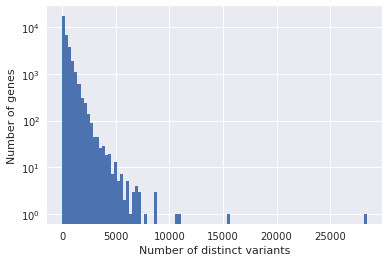

In [8]:
gene_vc.hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of distinct variants');

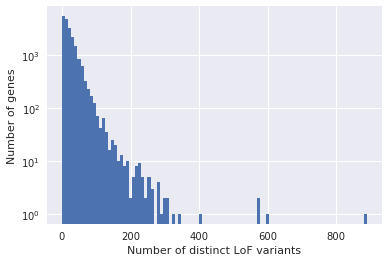

In [9]:
lof_only.Gene.value_counts().hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of distinct LoF variants');

We can see that most genes have less than 200 LoF variants.

## LoF Enrichment 

### Model

I'm going to calculate effect sizes and standard errors using the methods from http://biorxiv.org/lookup/doi/10.1101/077180. In particular, we can calculate
a bias-corrected log odds ratio and squared standard error as

$$\hat\beta_i = \log(\textrm{OR}_i) = \log\left(\frac{(0.5 + \textrm{LoF}_{a})(0.5 + \textrm{notLoF}_{b})}
{(0.5 + \textrm{notLoF}_{a})(0.5 + \textrm{LoF}_{b})}\right)$$

$$\hat{\textrm{SE}_i}^2 = \frac{1}{0.5 + \textrm{LoF}_{a}} + \frac{1}{0.5 + \textrm{LoF}_{b}}
+ \frac{1}{0.5 + \textrm{notLoF}_{a}} + \frac{1}{0.5 + \textrm{notLoF}_{b}}
$$

for a gene $i$ and two population groups $a$ and $b$. To start, I will compare all other population groups
to the non-Finnish Europeans (NFE). We are interested in how many gene copies harbor an LoF
variant in each population. 

For the LoF counts, I will sum the number of LoF alleles observed for each gene. So if a gene has
one variant site that is LoF but that allele was observed 10 times, that gene will have a count of 10.
Similarly, a gene with 10 LoF sites that are each observed once would also have a count of 10. We are 
assuming that a single person doesn't harbor two LoF variants which should be reasonable if they have
a low frequency.

### Variant filtering

I will filter out LoF variants that 

* weren't genotyped in at least 80% of the subjects for all populations
* were assigned to more than one gene
* have an allele frequency greater than 5% in any population
* are low confidence

In [10]:
for pop in pops:
    print('{:.1f}% of variants genotyped at >80% for {}.'.format(
            (vrs['GP_{}'.format(pop)] > 0.80).sum() / float(vrs.shape[0]) * 100, 
            pop))

83.5% of variants genotyped at >80% for AFR.
81.7% of variants genotyped at >80% for AMR.
87.4% of variants genotyped at >80% for ASJ.
83.8% of variants genotyped at >80% for EAS.
82.2% of variants genotyped at >80% for FIN.
83.0% of variants genotyped at >80% for NFE.
82.6% of variants genotyped at >80% for OTH.
81.8% of variants genotyped at >80% for SAS.


In [11]:
for pop in pops:
    print('{:.1f}% of LoF variants genotyped at >80% for {}.'.format(
            (lof_only['GP_{}'.format(pop)] > 0.80).sum() / float(lof_only.shape[0]) * 100, 
            pop))

86.3% of LoF variants genotyped at >80% for AFR.
85.9% of LoF variants genotyped at >80% for AMR.
92.2% of LoF variants genotyped at >80% for ASJ.
86.8% of LoF variants genotyped at >80% for EAS.
85.8% of LoF variants genotyped at >80% for FIN.
86.3% of LoF variants genotyped at >80% for NFE.
86.4% of LoF variants genotyped at >80% for OTH.
86.2% of LoF variants genotyped at >80% for SAS.


In [12]:
# Remove sites that weren't called for at least 80% of haplotypes in all populations.
lof_only_f = lof_only[lof_only[[x for x in lof_only.columns if 'GP_' in x]].min(axis=1) > 0.8]
# Remove sites that are assigned to more than one gene.
lof_only_f = lof_only_f[lof_only_f.Gene.apply(lambda x: ',' not in x)]
# Remove sites that have an allele frequency greater than 5% in any population.
lof_only_f = lof_only_f[lof_only_f[[x for x in lof_only_f.columns if 'AF_' in x]].max(axis=1) < 0.05]
# Keep only high confidence sites.
lof_only_f = lof_only_f[lof_only_f.LoF == 'HC']

In [13]:
vc = lof_only_f.Gene.value_counts()
lof_gene = lof_only_f.drop(['CHROM', 'POS', 'REF', 'ALT'] + list(lof_only.columns[-16:]), axis=1).groupby('Gene').sum()
# We need to divide the AN numbers by the number of LoF variants per gene to get the average AN.
for pop in pops:
    lof_gene['AN_{}'.format(pop)] = ((lof_gene['AN_{}'.format(pop)] / vc).astype(int) - 
                                     lof_gene['AC_{}'.format(pop)])
lof_gene = lof_gene[gtable.ix[lof_gene.index, 'gene_type'] == 'protein_coding']

In [14]:
def calc_summary_stats(df, popb, popa='NFE'):    
    lofa = df['AC_{}'.format(popa)]
    not_lofa = df['AN_{}'.format(popa)] - lofa
    lofb = df['AC_{}'.format(popb)]
    not_lofb = df['AN_{}'.format(popb)] - lofb
    
    beta = np.log(((0.5 + not_lofa) * (0.5 + lofb)) / ((0.5 + lofa) * (0.5 + not_lofb)))
    stderr2 = 1 / (0.5 + not_lofa) + 1 / (0.5 + not_lofb) + 1 / (0.5 + lofa) + 1 / (0.5 + lofb)
    
    ss = pd.DataFrame({'beta':beta, 'se2':stderr2})
    
    return ss

In [15]:
summary_stats = {}
tpops = list(set(pops) - set(['NFE', 'OTH']))
for pop in tpops:
    summary_stats[pop] = beta, stderr2 = calc_summary_stats(lof_gene, pop)
    
for pop in tpops:
    summary_stats[pop].to_csv('{}_ss.tsv'.format(pop), sep='\t')

### Run model

In [17]:
# piemm_res_default = {}
# for pop in tpops:
#     betas = summary_stats[pop]['beta']
#     ses = np.sqrt(summary_stats[pop]['se2'])
#     ires, ores, gamma = piemm(betas, ses)
#     piemm_res_default[pop] = [ires, ores, gamma]
    
# piemm_res_var05 = {}
# for pop in tpops:
#     betas = summary_stats[pop]['beta']
#     ses = np.sqrt(summary_stats[pop]['se2'])
#     ires, ores, gamma = piemm(betas, ses, var1fix=0.5, var2fix=0.5)
#     piemm_res_var05[pop] = [ires, ores, gamma]
    
# piemm_res_var025 = {}
# for pop in tpops:
#     betas = summary_stats[pop]['beta']
#     ses = np.sqrt(summary_stats[pop]['se2'])
#     ires, ores, gamma = piemm(betas, ses, var1fix=0.25, var2fix=0.25)
#     piemm_res_var025[pop] = [ires, ores, gamma]
    
# piemm_res_notfix = {}
# for pop in tpops:
#     betas = summary_stats[pop]['beta']
#     ses = np.sqrt(summary_stats[pop]['se2'])
#     ires, ores, gamma = piemm(betas, ses, paramfix=False)
#     piemm_res_notfix[pop] = [ires, ores, gamma]
    
fn = 'piemm_res_01_05_05.pickle'
if os.path.exists(fn):
    piemm_res_01_05_05 = cPickle.load(open(fn))
else:
    piemm_res_01_05_05 = {}
    for pop in tpops:
        betas = summary_stats[pop]['beta']
        ses = np.sqrt(summary_stats[pop]['se2'])
        ires, ores, gamma = piemm(betas, ses, priorvar0=0.1**2, var1fix=0.05**2, var2fix=0.05**2)
        gamma.index = betas.index
        gamma = gamma / gamma.sum(axis=1).ix[0]
        piemm_res_01_05_05[pop] = [ires, ores, gamma]
        with open(fn, 'w') as f:
            cPickle.dump(piemm_res_01_05_05, f)
    
# piemm_res_02_05_05 = {}
# for pop in tpops:
#     betas = summary_stats[pop]['beta']
#     ses = np.sqrt(summary_stats[pop]['se2'])
#     ires, ores, gamma = piemm(betas, ses, priorvar0=0.2**2, var1fix=0.05**2, var2fix=0.05**2)
#     gamma.index = betas.index
#     gamma = gamma / gamma.sum(axis=1).ix[0]
#     piemm_res_02_05_05[pop] = [ires, ores, gamma]
    
# piemm_res_03_05_05 = {}
# for pop in tpops:
#     betas = summary_stats[pop]['beta']
#     ses = np.sqrt(summary_stats[pop]['se2'])
#     ires, ores, gamma = piemm(betas, ses, priorvar0=0.3**2, var1fix=0.05**2, var2fix=0.05**2)
#     gamma.index = betas.index
#     gamma = gamma / gamma.sum(axis=1).ix[0]
#     piemm_res_03_05_05[pop] = [ires, ores, gamma]

In [18]:
def plot_norms(mus, sigmas, ax=None, percent=0.99):
    mus = list(mus)
    sigmas = list(sigmas)
    # Define max and min.
    xmax = max([stats.norm.ppf(percent, mus[i], sigmas[i]) for i in range(len(mus))] + 
               [abs(stats.norm.ppf(1 - percent, mus[i], sigmas[i])) for i in range(len(mus))])
    xmin = -xmax
    x = np.linspace(xmin, xmax, 100)
    if ax is None:
        fig, ax = plt.subplots(1)
    for i in range(len(mus)):
        ax.plot(x, stats.norm.pdf(x, mus[i], sigmas[i]), label=i)
    ax.legend()
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group distributions')

def visualize_piemm_res(pop, piemm_res, summary_stats):
    display(HTML('<h4>Results for {}</h4>'.format(pop)))
    ires, ores, gamma = piemm_res[pop]
    sum_stats = summary_stats[pop]
    fig, axs = plt.subplots(6, 2, figsize=(10, 15))
    display(ores)
    
    plot_num = 0
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meanmu)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95mu'], ores.ix[i, 'u95mu'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\mu$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meansd)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95sd'], ores.ix[i, 'u95sd'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\sigma$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meanpi)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95pi'], ores.ix[i, 'u95pi'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\pi$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['mu'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\mu$')
    ax.set_title('$\mu$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['sigma'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\sigma$')
    ax.set_title('$\sigma$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['pi'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\pi$')
    ax.set_title('$\pi$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    plot_norms(ores.meanmu, ores.meansd, ax=ax)
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    sum_stats['group'] = gamma.idxmax(axis=1).values
    xmax = np.ceil(sum_stats.beta.abs().max())
    xmin = -xmax
    step = (xmax - xmin) / 100.
    toplot = []
    for i in [2, 0, 1]:
        toplot.append(sum_stats.ix[sum_stats.group == i, 'beta'].values)
    ax.hist(toplot, stacked=True, bins=np.arange(xmin, xmax + step, step), label=[2, 0, 1], 
            color=[sns.color_palette()[2], sns.color_palette()[0], sns.color_palette()[1]])
    ax.set_xlabel('Beta')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of betas stratified by group membership')
    ax.legend()
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 2
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
    xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
    xmax = stats.norm.ppf(0.99, mu, sigma)
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 0
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
    xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
    xmax = stats.norm.ppf(0.99, mu, sigma)
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 1
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
    xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
    xmax = stats.norm.ppf(0.99, mu, sigma)
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plt.tight_layout()
    plt.show();

## Results

### var0 = $0.1^2$, var1 = var2 = $0.05^2$

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.583038,0.10,0.000000,0.594877,0.10,0.000000,0.609154,0.10
1,1.180082,0.256452,0.05,1.203828,0.264507,0.05,1.226559,0.272005,0.05
2,-1.225397,0.131286,0.05,-1.189380,0.140615,0.05,-1.147111,0.150411,0.05


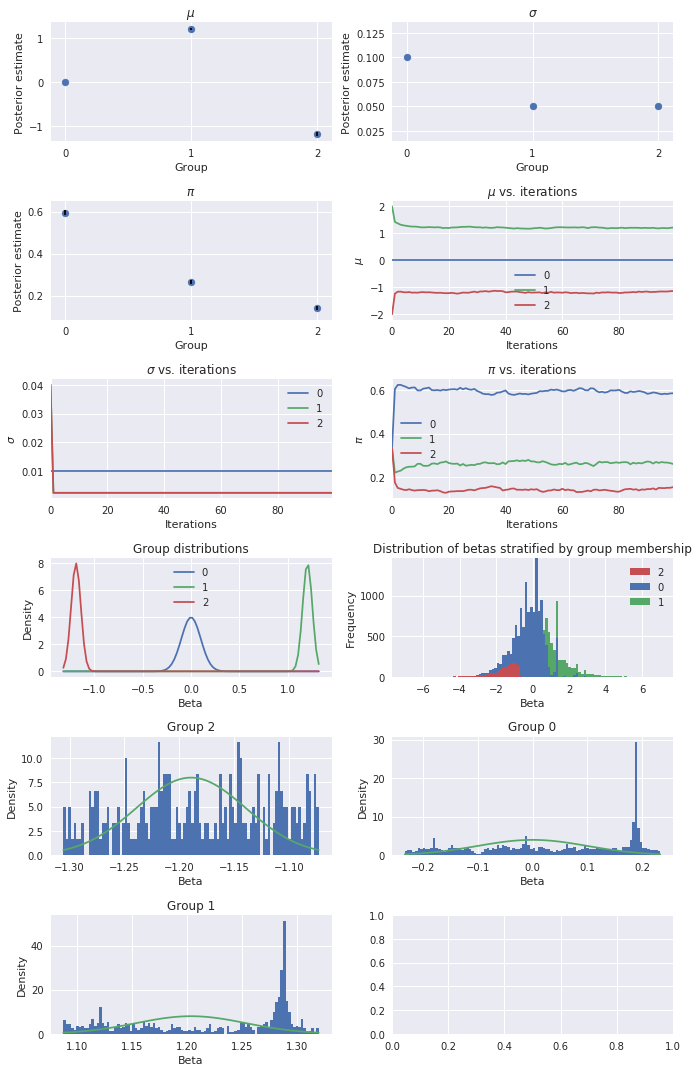

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.145230,0.10,0.000000,0.165865,0.10,0.000000,0.187579,0.10
1,0.223904,0.520078,0.05,0.250906,0.540505,0.05,0.279369,0.552681,0.05
2,-1.027278,0.282165,0.05,-0.996855,0.293630,0.05,-0.970948,0.311521,0.05


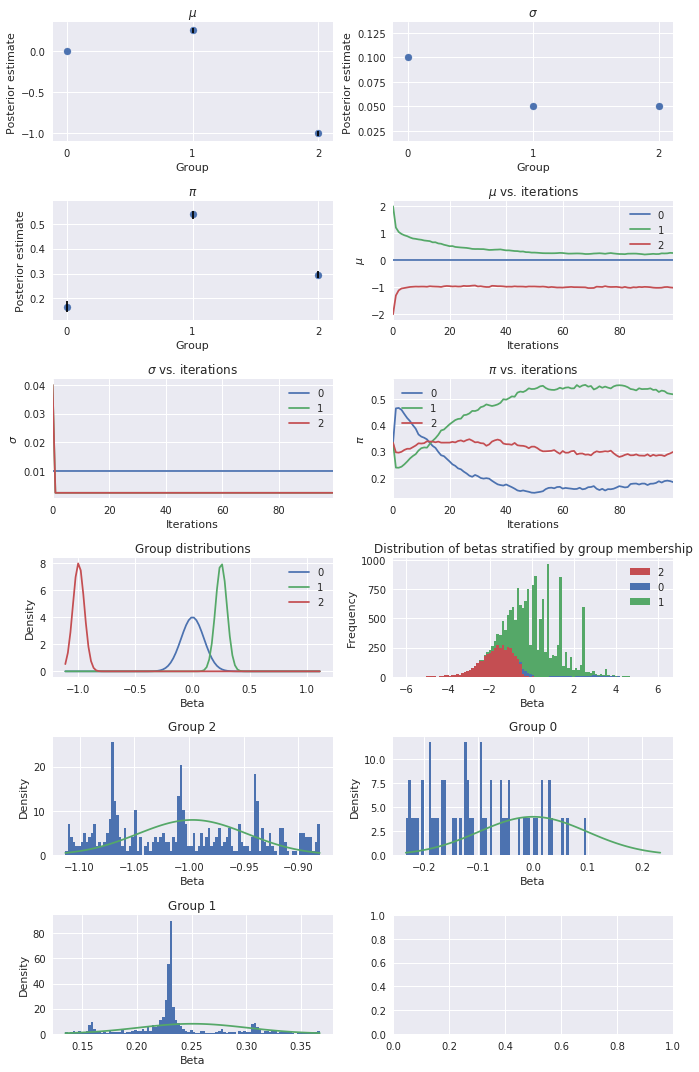

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.553048,0.10,0.000000,0.564453,0.10,0.000000,0.573761,0.10
1,1.188115,0.316374,0.05,1.212239,0.325288,0.05,1.238173,0.336938,0.05
2,-1.718279,0.104523,0.05,-1.672865,0.110259,0.05,-1.626950,0.114988,0.05


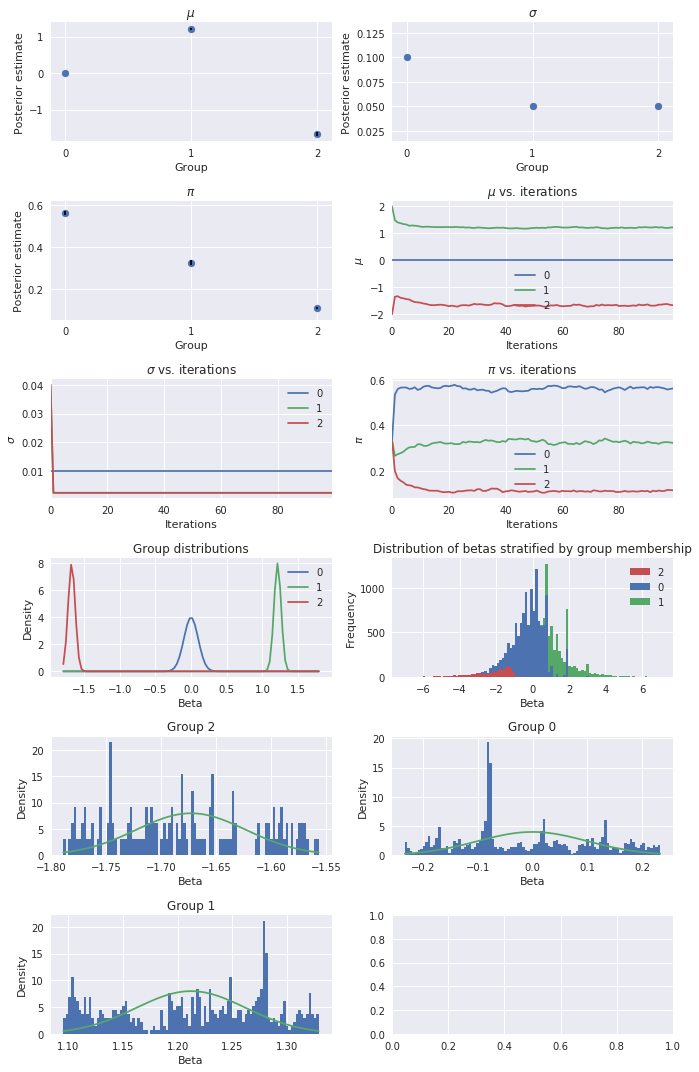

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.513218,0.10,0.000000,0.526457,0.10,0.000000,0.538207,0.10
1,0.965968,0.256585,0.05,1.006837,0.266289,0.05,1.031648,0.276413,0.05
2,-0.973891,0.197362,0.05,-0.950394,0.207254,0.05,-0.931889,0.213495,0.05


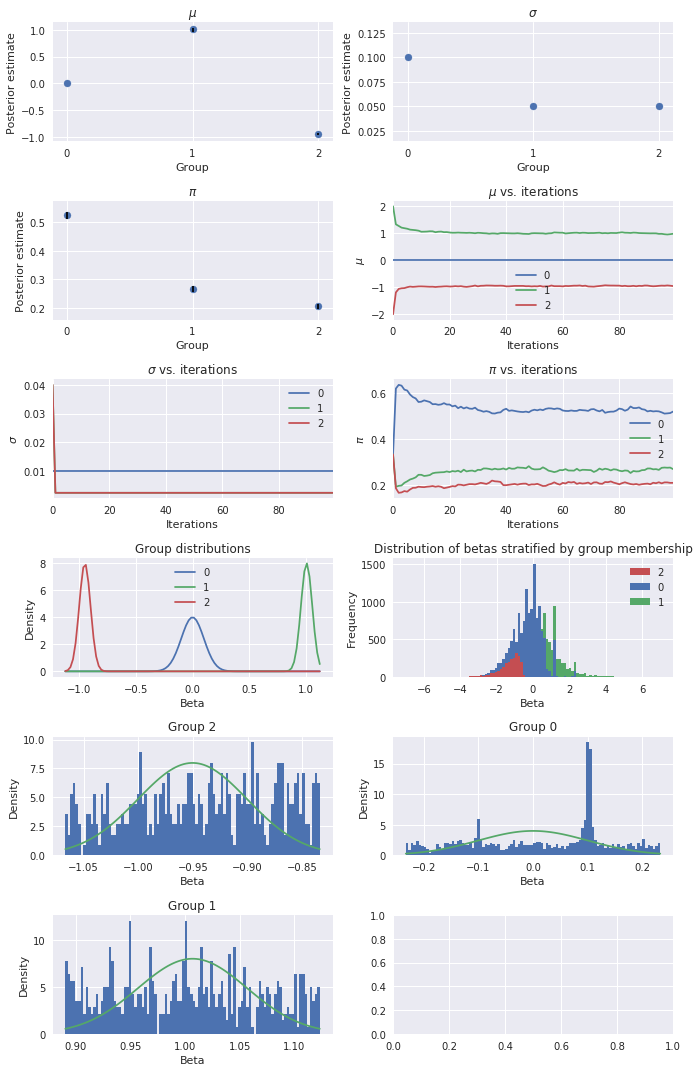

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.244469,0.10,0.000000,0.362147,0.10,0.00000,0.488202,0.10
1,0.007566,0.102044,0.05,0.243266,0.196299,0.05,0.64625,0.291980,0.05
2,-1.350959,0.406137,0.05,-1.312935,0.441554,0.05,-1.27515,0.480896,0.05


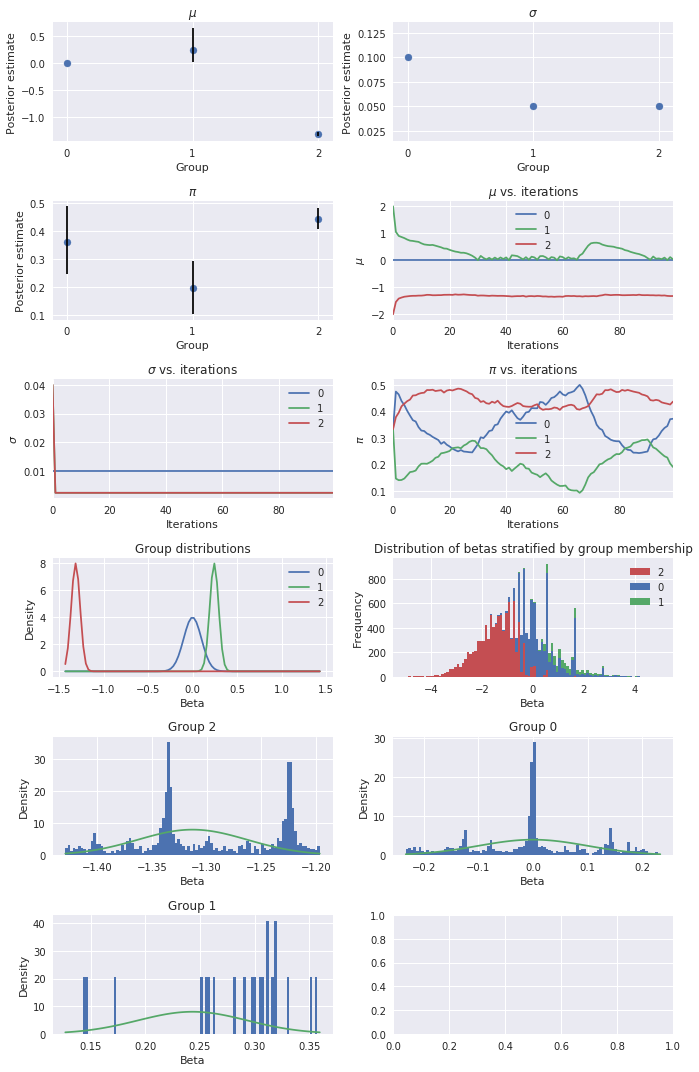

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.542220,0.10,0.000000,0.555679,0.10,0.000000,0.568346,0.10
1,1.641533,0.266246,0.05,1.669635,0.276685,0.05,1.705119,0.285338,0.05
2,-0.729375,0.156286,0.05,-0.683104,0.167636,0.05,-0.655108,0.178853,0.05


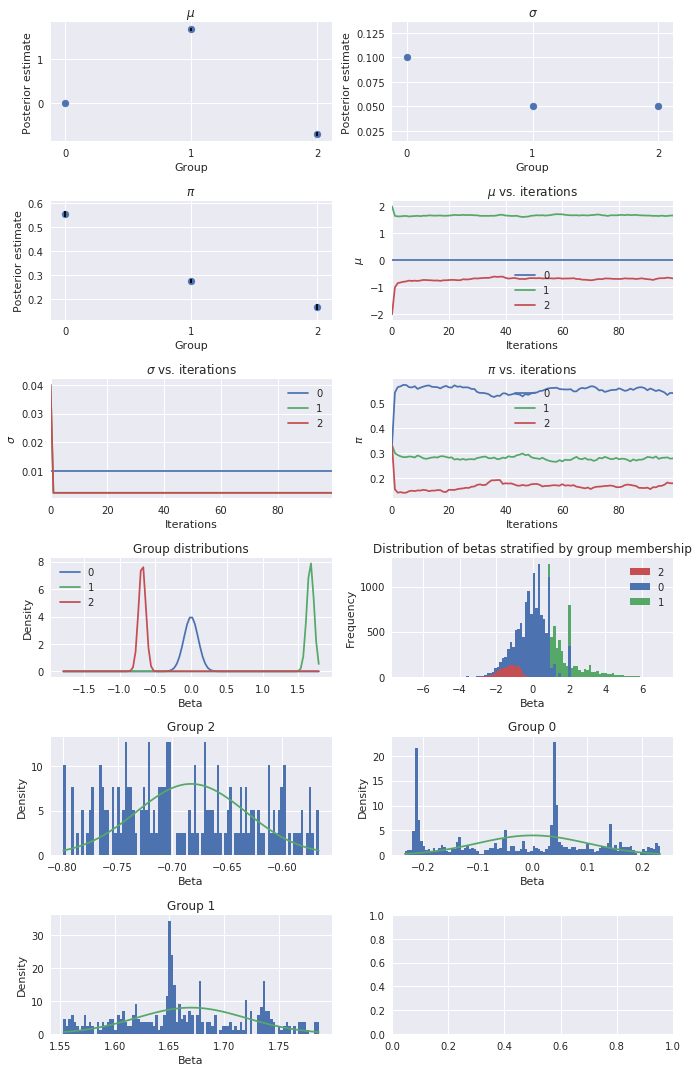

In [19]:
for pop in tpops:
    visualize_piemm_res(pop, piemm_res_01_05_05, summary_stats)

### var0 = $0.2^2$, var1 = var2 = $0.05^2$

### var0 = $0.3^2$, var1 = var2 = $0.05^2$

### Variance = 1

### Variance = 0.5

### Variance = 0.25

### Variance not fixed

### PCSK9 Results

In [20]:
pcsk9 = gtable[gtable.gene_name == 'PCSK9'].index[0]

In [21]:
for pop in tpops:
    print(pop, summary_stats[pop].ix[pcsk9, 'beta'])

('SAS', 0.16473830922778449)
('ASJ', 0.88418973930262135)
('EAS', -0.61494540875898407)
('AMR', 0.78282360716328969)
('FIN', -3.0632181978950879)
('AFR', 1.9574059343929402)


In [22]:
t = {}
for pop in tpops:
    t[pop] = piemm_res_01_05_05[pop][2].ix[pcsk9]
t = pd.DataFrame(t)
t.index = ['similar', 'enriched', 'depleted']
t

,AFR,AMR,ASJ,EAS,FIN,SAS
similar,0.0,0.0,0.039216,0.960784,0.215686,1.0
enriched,1.0,1.0,0.960784,0.000000,0.000000,0.0
depleted,0.0,0.0,0.000000,0.039216,0.784314,0.0


## Compare AFR vs. AMR

I want to compare the genes enriched for LoF variants
among African ancestry and Latino ancestry individuals.
We'll use some gene lists to focus in on interesting genes.

In [23]:
afr_gamma = piemm_res_01_05_05['AFR'][2]
amr_gamma = piemm_res_01_05_05['AMR'][2]

In [24]:
afr_enriched = set(afr_gamma.idxmax(axis=1)[afr_gamma.idxmax(axis=1) == 1].index)
amr_enriched = set(amr_gamma.idxmax(axis=1)[amr_gamma.idxmax(axis=1) == 1].index)

In [25]:
print('{:,} enriched genes for AFR.'.format(len(afr_enriched)))
print('{:,} enriched genes for AMR.'.format(len(amr_enriched)))
print('{:,} shared enriched genes for AFR and AMR.'.format(len(afr_enriched & amr_enriched)))

3,892 enriched genes for AFR.
3,547 enriched genes for AMR.
1,462 shared enriched genes for AFR and AMR.


In [26]:
for pop in pops:
    lof_gene['AF_{}'.format(pop)] = lof_gene['AC_{}'.format(pop)] / lof_gene['AN_{}'.format(pop)]

### FDA approved drug targets

In [27]:
fn = ('/home/cdeboeve/cdeboeve_projects/repos/macarthur-lab/gene_lists/lists/fda_approved_drug_targets.tsv')
fda_drug_targets = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in fda_drug_targets.index:
    ind.append(gtable[gtable.gene_name == fda_drug_targets[i]].index[0])
fda_drug_targets.index = ind

print('{:,} FDA drug targets enriched for AFR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) & set(fda_drug_targets))))
print('{:,} FDA drug targets enriched for AMR.'.format(len(set(gtable.ix[amr_enriched, 'gene_name']) & set(fda_drug_targets))))
print('{:,} shared enriched FDA drug targets for AFR and AMR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) &
                                                                          set(gtable.ix[amr_enriched, 'gene_name']) &
                                                                          set(fda_drug_targets))))

fda_set = (afr_enriched | amr_enriched) & set(fda_drug_targets.index)
fda = pd.DataFrame(index=fda_set, columns=['symbol', 'AFR_beta', 'AMR_beta'])
fda['symbol'] = gtable.ix[fda.index, 'gene_name']
fda.ix[afr_enriched & set(fda.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(fda.index), 'beta']
fda.ix[amr_enriched & set(fda.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(fda.index), 'beta']
fda = fda.sort_values(by='symbol')
fda['AF_AFR'] = lof_gene.AF_AFR.ix[fda.index]
fda['AF_AMR'] = lof_gene.AF_AMR.ix[fda.index]
fda['AF_NFE'] = lof_gene.AF_NFE.ix[fda.index]
fda['AC_AFR'] = lof_gene.AC_AFR.ix[fda.index]
fda['AC_AMR'] = lof_gene.AC_AMR.ix[fda.index]
fda['AC_NFE'] = lof_gene.AC_NFE.ix[fda.index]

51 FDA drug targets enriched for AFR.
53 FDA drug targets enriched for AMR.
16 shared enriched FDA drug targets for AFR and AMR.


### Nelson et al. drug targets

In [28]:
fn = ('/home/cdeboeve/cdeboeve_projects/repos/macarthur-lab/gene_lists/lists/drug_targets_nelson.tsv')
nelson_drug_targets = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in nelson_drug_targets.index:
    if len(gtable[gtable.gene_name == nelson_drug_targets[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == nelson_drug_targets[i]].index[0])
    else:
        ind.append('NaN')
nelson_drug_targets.index = ind
nelson_drug_targets = nelson_drug_targets.drop('NaN')

print('{:,} Nelson drug targets enriched for AFR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) & set(nelson_drug_targets))))
print('{:,} Nelson drug targets enriched for AMR.'.format(len(set(gtable.ix[amr_enriched, 'gene_name']) & set(nelson_drug_targets))))
print('{:,} shared enriched Nelson drug targets for AFR and AMR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) &
                                                                          set(gtable.ix[amr_enriched, 'gene_name']) &
                                                                          set(nelson_drug_targets))))

nelson_set = (afr_enriched | amr_enriched) & set(nelson_drug_targets.index)
nelson = pd.DataFrame(index=nelson_set, columns=['symbol', 'AFR_beta', 'AMR_beta'])
nelson['symbol'] = gtable.ix[nelson.index, 'gene_name']
nelson.ix[afr_enriched & set(nelson.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(nelson.index), 'beta']
nelson.ix[amr_enriched & set(nelson.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(nelson.index), 'beta']
nelson = nelson.sort_values(by='symbol')
nelson['AF_AFR'] = lof_gene.AF_AFR.ix[nelson.index]
nelson['AF_AMR'] = lof_gene.AF_AMR.ix[nelson.index]
nelson['AF_NFE'] = lof_gene.AF_NFE.ix[nelson.index]
nelson['AC_AFR'] = lof_gene.AC_AFR.ix[nelson.index]
nelson['AC_AMR'] = lof_gene.AC_AMR.ix[nelson.index]
nelson['AC_NFE'] = lof_gene.AC_NFE.ix[nelson.index]

38 Nelson drug targets enriched for AFR.
40 Nelson drug targets enriched for AMR.
16 shared enriched Nelson drug targets for AFR and AMR.


### Rivas IBD genes

In [29]:
fn = ('/home/cdeboeve/cdeboeve_projects/sandbox/lof_enrichment/ibd_gwas.locset')
ibd_genes = pd.read_table(fn, header=None, squeeze=True).drop(1, axis=1)[0].drop_duplicates()
ind = []
for i in ibd_genes.index:
    if len(gtable[gtable.gene_name == ibd_genes[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == ibd_genes[i]].index[0])
    else:
        ind.append('NaN')
ibd_genes.index = ind
ibd_genes = ibd_genes.drop('NaN')

print('{:,} IBD genes enriched for AFR.'.format(len(afr_enriched & set(ibd_genes.index))))
print('{:,} IBD genes enriched for AMR.'.format(len(amr_enriched & set(ibd_genes.index))))
print('{:,} shared enriched IBD genes for AFR and AMR.'.format(len(afr_enriched & 
                                                                   amr_enriched & 
                                                                   set(ibd_genes.index))))

ibd = pd.DataFrame(index=(afr_enriched | amr_enriched) & set(ibd_genes.index), 
                   columns=['symbol', 'AFR_beta', 'AMR_beta'])
ibd['symbol'] = gtable.ix[ibd.index, 'gene_name']
ibd.ix[afr_enriched & set(ibd.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(ibd.index), 'beta']
ibd.ix[amr_enriched & set(ibd.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(ibd.index), 'beta']
ibd = ibd.sort_values(by='symbol')
ibd['AF_AFR'] = lof_gene.AF_AFR.ix[ibd.index]
ibd['AF_AMR'] = lof_gene.AF_AMR.ix[ibd.index]
ibd['AF_NFE'] = lof_gene.AF_NFE.ix[ibd.index]
ibd['AC_AFR'] = lof_gene.AC_AFR.ix[ibd.index]
ibd['AC_AMR'] = lof_gene.AC_AMR.ix[ibd.index]
ibd['AC_NFE'] = lof_gene.AC_NFE.ix[ibd.index]

58 IBD genes enriched for AFR.
41 IBD genes enriched for AMR.
15 shared enriched IBD genes for AFR and AMR.


### Autosomal recessive genes

In [30]:
fn = ('/home/cdeboeve/cdeboeve_projects/repos/macarthur-lab/gene_lists/lists/all_ar.tsv')
auto_recessive_genes = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in auto_recessive_genes.index:
    if len(gtable[gtable.gene_name == auto_recessive_genes[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == auto_recessive_genes[i]].index[0])
    else:
        ind.append('NaN')
auto_recessive_genes.index = ind
auto_recessive_genes = auto_recessive_genes.drop('NaN')

print('{:,} autosomal recessive genes enriched for AFR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) & set(auto_recessive_genes))))
print('{:,} autosomal recessive genes enriched for AMR.'.format(len(set(gtable.ix[amr_enriched, 'gene_name']) & set(auto_recessive_genes))))
print('{:,} shared enriched autosomal recessive genes for AFR and AMR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) &
                                                                          set(gtable.ix[amr_enriched, 'gene_name']) &
                                                                          set(auto_recessive_genes))))

auto_recessive = pd.DataFrame(index=(afr_enriched | amr_enriched) & set(auto_recessive_genes.index),
                              columns=['symbol', 'AFR_beta', 'AMR_beta'])
auto_recessive['symbol'] = gtable.ix[auto_recessive.index, 'gene_name']
auto_recessive.ix[afr_enriched & set(auto_recessive.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(auto_recessive.index), 'beta']
auto_recessive.ix[amr_enriched & set(auto_recessive.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(auto_recessive.index), 'beta']
auto_recessive = auto_recessive.sort_values(by='symbol')
auto_recessive['AF_AFR'] = lof_gene.AF_AFR.ix[auto_recessive.index]
auto_recessive['AF_AMR'] = lof_gene.AF_AMR.ix[auto_recessive.index]
auto_recessive['AF_NFE'] = lof_gene.AF_NFE.ix[auto_recessive.index]
auto_recessive['AC_AFR'] = lof_gene.AC_AFR.ix[auto_recessive.index]
auto_recessive['AC_AMR'] = lof_gene.AC_AMR.ix[auto_recessive.index]
auto_recessive['AC_NFE'] = lof_gene.AC_NFE.ix[auto_recessive.index]

199 autosomal recessive genes enriched for AFR.
193 autosomal recessive genes enriched for AMR.
56 shared enriched autosomal recessive genes for AFR and AMR.


### Rivas schizophrenia genes

In [31]:
fn = ('/home/cdeboeve/cdeboeve_projects/sandbox/lof_enrichment/tier1.txt')
schiz_genes = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in schiz_genes.index:
    if len(gtable[gtable.gene_name == schiz_genes[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == schiz_genes[i]].index[0])
    else:
        ind.append('NaN')
schiz_genes.index = ind
schiz_genes = schiz_genes.drop('NaN')

print('{:,} schizophrenia genes enriched for AFR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) & set(schiz_genes))))
print('{:,} schizophrenia genes enriched for AMR.'.format(len(set(gtable.ix[amr_enriched, 'gene_name']) & set(schiz_genes))))
print('{:,} shared enriched schizophrenia genes for AFR and AMR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) &
                                                                          set(gtable.ix[amr_enriched, 'gene_name']) &
                                                                          set(schiz_genes))))

schiz = pd.DataFrame(index=(afr_enriched | amr_enriched) & set(schiz_genes.index),
                              columns=['symbol', 'AFR_beta', 'AMR_beta'])
schiz['symbol'] = gtable.ix[schiz.index, 'gene_name']
schiz.ix[afr_enriched & set(schiz.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(schiz.index), 'beta']
schiz.ix[amr_enriched & set(schiz.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(schiz.index), 'beta']
schiz = schiz.sort_values(by='symbol')
schiz['AF_AFR'] = lof_gene.AF_AFR.ix[schiz.index]
schiz['AF_AMR'] = lof_gene.AF_AMR.ix[schiz.index]
schiz['AF_NFE'] = lof_gene.AF_NFE.ix[schiz.index]
schiz['AC_AFR'] = lof_gene.AC_AFR.ix[schiz.index]
schiz['AC_AMR'] = lof_gene.AC_AMR.ix[schiz.index]
schiz['AC_NFE'] = lof_gene.AC_NFE.ix[schiz.index]

15 schizophrenia genes enriched for AFR.
10 schizophrenia genes enriched for AMR.
5 shared enriched schizophrenia genes for AFR and AMR.


I'll make an Excel sheet with these results.

In [32]:
writer = pd.ExcelWriter('afr_amr_enriched.xlsx')
fda.to_excel(writer, 'fda_drug_targets')
nelson.to_excel(writer, 'nelson_drug_targets')
ibd.to_excel(writer, 'ibd_genes')
auto_recessive.to_excel(writer, 'autosomal_recessive')
schiz.to_excel(writer, 'schizophrenia_genes')
writer.save()

## Further analysis

In [33]:
fda.max()

symbol            UGCG
AFR_beta       4.95258
AMR_beta       3.53191
AF_AFR       0.0433768
AF_AMR      0.00684133
AF_NFE      0.00539901
AC_AFR             632
AC_AMR             223
AC_NFE             598
dtype: object

In [34]:
nelson.max()

symbol           TRPM8
AFR_beta       5.37324
AMR_beta       3.79077
AF_AFR        0.038304
AF_AMR      0.00323266
AF_NFE      0.00115195
AC_AFR             561
AC_AMR             108
AC_NFE             128
dtype: object

In [35]:
schiz[schiz.AF_AFR > 0.01]

,symbol,AFR_beta,AMR_beta,AF_AFR,AF_AMR,AF_NFE,AC_AFR,AC_AMR,AC_NFE
ENSG00000120885,CLU,4.83977,1.99109,0.019439,0.001134,0.000153,291,38,17
ENSG00000002822,MAD1L1,3.17875,NaN,0.016799,0.000929,0.000708,248,31,78


In [36]:
schiz.max()

symbol          TSNARE1
AFR_beta        4.83977
AMR_beta        1.99109
AF_AFR        0.0194389
AF_AMR       0.00113396
AF_NFE      0.000707785
AC_AFR              291
AC_AMR               38
AC_NFE               78
dtype: object

In [37]:
ibd[ibd.AF_AFR > 0.01]

,symbol,AFR_beta,AMR_beta,AF_AFR,AF_AMR,AF_NFE,AC_AFR,AC_AMR,AC_NFE
ENSG00000176920,FUT2,4.59669,2.52496,0.024680,0.003167,0.000251,368,106,28
ENSG00000142224,IL19,4.80249,2.33746,0.010235,0.000866,0.000081,155,29,9
